Machine Learning Assignment 2 

In [410]:
# imports
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob



In [411]:
# setup data 
image_list = []
    # -3 means back one directory
# filename/shape/type/label
for filepath in glob.glob('images/*/*/*.png', recursive=True):
     filename = filepath.split("\\")[-1]
     sign_shape = filepath.split("\\")[-2]
     sign_type = filepath.split("\\")[-3]
     
     image_list.append((filepath,sign_shape,sign_type))
     
data = pd.DataFrame(data=image_list, columns=['image_path','sign_type', 'sign_shape'])


Dataframes for training and validation

In [412]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

# plt.figure(figsize=(16,4))
# for i, image_path in enumerate(rand_data):
#     im = np.asarray(Image.open(image_path))
#     plt.subplot(1,4,i+1)
#     plt.imshow(im,cmap='gray')
#     plt.axis('off')
#     
# plt.show()

d = {'diamond':0, 'hex':1, 'round':2, 'square':3, 'triangle':4}
data['shapes_num'] = data['sign_shape'].map(d, na_action='ignore')



train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])
print("Train")
print(train)
print("test")
print(test)
print("validate")
print(validate)

N_train_images = train.shape[0]
N_val_images = validate.shape[0]
N_test_images = test.shape[0]




Train
                                         image_path         sign_type  \
3359        images\triangle\warning\00899_00002.png           warning   
3392        images\triangle\warning\00987_00000.png           warning   
2755          images\square\parking\01679_00000.png           parking   
2895        images\triangle\giveway\01101_00000.png           giveway   
1755             images\round\speed\01916_00001.png             speed   
...                                             ...               ...   
612     images\round\limitedtraffic\00019_00002.png    limitedtraffic   
3665        images\triangle\warning\01850_00001.png           warning   
1952  images\round\trafficdirective\01959_00000.png  trafficdirective   
3444        images\triangle\warning\01103_00000.png           warning   
2422          images\square\laneend\00471_00001.png           laneend   

     sign_shape  shapes_num  
3359   triangle           4  
3392   triangle           4  
2755     square           3

In [413]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_crossentropy, sparse_categorical_accuracy


In [414]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from keras.layers import GaussianNoise

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_cnn = Sequential()

# input
model_cnn.add(Input(shape=(28, 28, 3)))
model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights


# CONV => RELU => BN => POOL
model_cnn.add(Conv2D(8, (5, 5), padding="same"))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model_cnn.add(Conv2D(16, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation("relu"))
# model_cnn.add(Conv2D(16, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
# model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
model_cnn.add(Conv2D(32, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation("relu"))
# model_cnn.add(Conv2D(16, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
# model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))


# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
# model_cnn.add(Conv2D(64, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Conv2D(64, (3, 3), padding="same",kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# model_cnn.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model_cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model_cnn.add(Conv2D(256, (1, 1), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_cnn.add(Dropout(0.2))

# second set of FC => RELU layers
model_cnn.add(Flatten())
# model_cnn.add(Dense(128))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten())


model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))



model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_48 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 28, 28, 8)         208       
_________________________________________________________________
activation_330 (Activation)  (None, 28, 28, 8)         0         
_________________________________________________________________
batch_normalization_175 (Bat (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 14, 14, 16)        1168      
_________________________________________________________________
activation_331 (Activation)  (None, 14, 14, 16)      

In [415]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,fill_mode='nearest')
                                
                                   
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 60

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validate,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./',
        x_col="image_path",
        y_col="sign_shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode=None, shuffle=False
)



Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.
Found 740 validated image filenames.


In [416]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0

    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because the generator loops indefinitely
            break

    return np.mean(loss_hold), np.mean(acc_hold)


In [417]:
def train_model(model_, num_epoch=40, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))

    # model_.save('model.h5')
    # print('Model saved')

    return np.asarray(res)

In [418]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

res = train_model(model_cnn, num_epoch=40, verbose=True)
# model_cnn.fit_generator(train_generator,
#                               validation_data=validation_generator, epochs=30)
# model_cnn.save_weights('first_try.h5')

Training epoch 0: Loss = 1.9813919067382812, Accuracy = 0.296556681394577
Validation epoch 0: Loss = 1.8310419583931952, Accuracy = 0.4910256266593933
Training epoch 1: Loss = 1.648881435394287, Accuracy = 0.48339059948921204
Validation epoch 1: Loss = 1.7477218481210561, Accuracy = 0.48846152424812317
Training epoch 2: Loss = 1.408337116241455, Accuracy = 0.6103355288505554
Validation epoch 2: Loss = 1.701768469199156, Accuracy = 0.4884614944458008
Training epoch 3: Loss = 1.2611494064331055, Accuracy = 0.6597343683242798
Validation epoch 3: Loss = 1.6707866479188966, Accuracy = 0.4884614944458008
Training epoch 4: Loss = 1.1267896890640259, Accuracy = 0.728368878364563
Validation epoch 4: Loss = 1.656761449422592, Accuracy = 0.48076918721199036
Training epoch 5: Loss = 1.0872975587844849, Accuracy = 0.7406817078590393
Validation epoch 5: Loss = 1.6075320659539638, Accuracy = 0.4961538314819336
Training epoch 6: Loss = 1.0229161977767944, Accuracy = 0.7628282308578491
Validation epoch

In [419]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])


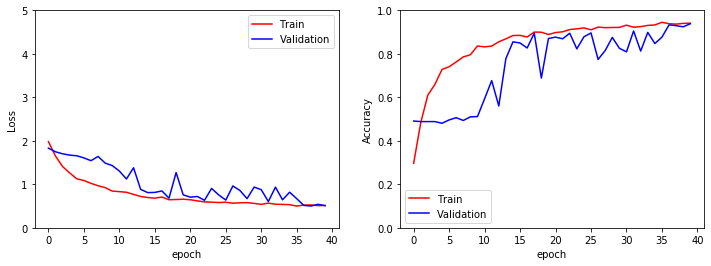

In [420]:
plot_results(res)

In [421]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import model_from_json


pred = model_cnn.predict(test_generator)
print(np.argmax(pred[0]))

predicted_class_indices=np.argmax(pred,axis=1)

print(test_generator)

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]


filenames=test_generator.filenames

results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
print(results)

2
                                          Filename Predictions
0             images\round\bicycle\01713_00002.png       round
1            images\square\laneend\01353_00000.png      square
2           images\round\noparking\00829_00001.png       round
3    images\round\trafficdirective\00535_00000.png       round
4          images\triangle\giveway\01936_00000.png    triangle
..                                             ...         ...
735        images\round\roundabout\01352_00001.png       round
736        images\round\roundabout\01313_00000.png       round
737             images\round\speed\01244_00001.png       round
738      images\diamond\rightofway\00937_00002.png     diamond
739                images\hex\stop\01162_00002.png       round

[740 rows x 2 columns]
